In [58]:
# pip install pyreadr

In [79]:
# Import relevant packages
import pandas as pd
import numpy as np
import pyreadr
import math

In [80]:
# Import relevant packages
rdata_read = pyreadr.read_r("d:/Users/Manuela/Documents/GitHub/ECO224/Labs/data/wage2015_subsample_inference.Rdata")

# Extracting the data frame from rdata_read
data = rdata_read[ 'data' ]

data.shape

(5150, 20)

To start our analysis, we compare the sample means given gender:

In [81]:
Z_scl = data[data[ 'scl' ] == 1 ]
Z_clg = data[data[ 'clg' ] == 1 ]
Z_data = pd.concat([Z_scl,Z_clg])

Z = Z_data[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_female = Z_data[Z_data[ 'sex' ] == 1 ]
Z_female = data_female[ ["lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1"] ]

data_male = Z_data[ Z_data[ 'sex' ] == 0 ]
Z_male = data_male[ [ "lwage","sex","shs","hsg","scl","clg","ad","ne","mw","so","we","exp1" ] ]


table = np.zeros( (12, 3) )
table[:, 0] = Z.mean().values
table[:, 1] = Z_male.mean().values
table[:, 2] = Z_female.mean().values
table_pandas = pd.DataFrame( table, columns = [ 'All', 'Men', 'Women'])
table_pandas.index = ["Log Wage","Sex","Less then High School","High School Graduate","Some College","Collage Graduate","Advanced Degree", "Northeast","Midwest","South","West","Experience"]
table_html = table_pandas.to_html()

table_pandas

,All,Men,Women
Log Wage,3.000022,3.038412,2.956904
Sex,0.470991,0.000000,1.000000
Less then High School,0.000000,0.000000,0.000000
High School Graduate,0.000000,0.000000,0.000000
Some College,0.466754,0.481824,0.449827
Collage Graduate,0.533246,0.518176,0.550173
Advanced Degree,0.000000,0.000000,0.000000
Northeast,0.226532,0.219347,0.234602
Midwest,0.265971,0.261245,0.271280
South,0.285854,0.290819,0.280277


In [82]:
print( table_html )

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>All</th>
      <th>Men</th>
      <th>Women</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Log Wage</th>
      <td>3.000022</td>
      <td>3.038412</td>
      <td>2.956904</td>
    </tr>
    <tr>
      <th>Sex</th>
      <td>0.470991</td>
      <td>0.000000</td>
      <td>1.000000</td>
    </tr>
    <tr>
      <th>Less then High School</th>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>High School Graduate</th>
      <td>0.000000</td>
      <td>0.000000</td>
      <td>0.000000</td>
    </tr>
    <tr>
      <th>Some College</th>
      <td>0.466754</td>
      <td>0.481824</td>
      <td>0.449827</td>
    </tr>
    <tr>
      <th>Collage Graduate</th>
      <td>0.533246</td>
      <td>0.518176</td>
      <td>0.550173</td>
    </tr>
    <tr>
      <th>Advanced Degree</th>
      <td>0.000000</td>
      <td>0.000000</td>
 

In [83]:
data_female['lwage'].mean() - data_male['lwage'].mean()

-0.08150855508736754

We obtained that the unconditional gender wage gap is about $8,15$% for the group of never married workers (women with Some college and College graduate get paid less on average). We also observe that never married working women are relatively more educated than working men and have lower working experience.

This unconditional (predictive) effect of gender equals the coefficient $\beta$ in the univariate ols regression of $Y$ on $D$:

$$\begin{align}
\log(Y) =\beta D + \epsilon.
\end{align}$$

In [84]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [85]:
nocontrol_model = smf.ols( formula = 'lwage ~ sex', data = Z_data)
nocontrol_est = nocontrol_model.fit().summary2().tables[1]['Coef.']['sex']
HCV_coefs = nocontrol_model.fit().cov_HC0
nocontrol_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# print unconditional effect of gender and the corresponding standard error
print( f'The estimated gender coefficient is {nocontrol_est} and the corresponding robust standard error is {nocontrol_se}' )

The estimated gender coefficient is -0.08150855508736031 and the corresponding robust standard error is 0.019579647767772337


Next, we run an ols regression of $Y$ on $(D,W)$ to control for the effect of covariates summarized in $W$:

$$\begin{align}
\log(Y) =\beta_1 D  + \beta_2' W + \epsilon.
\end{align}$$
$W$ controls for experience, education, region, and occupation and industry indicators plus transformations and two-way interactions.

Now, we are going to run the ols regression with controls.

# Ols regression with controls

In [106]:
flex = 'lwage ~ sex + (exp1+exp2+exp3+exp4)*(clg+occ2+ind2+mw+so+we)'

# The smf api replicates R script when it transform data
control_model = smf.ols( formula = flex, data = Z_data )
control_est = control_model.fit().summary2().tables[1]['Coef.']['sex']

print(control_model.fit().summary2().tables[1])
print( f"Coefficient for OLS with controls {control_est}" )

HCV_coefs = control_model.fit().cov_HC0
control_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

               Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
Intercept   2.985101  0.336482  8.871492  1.250129e-18  2.325327  3.644876
occ2[T.10]  0.091982  0.243220  0.378184  7.053225e-01 -0.384925  0.568888
occ2[T.11] -0.499418  0.436858 -1.143202  2.530511e-01 -1.356010  0.357175
occ2[T.12]  0.190101  0.341142  0.557249  5.774012e-01 -0.478810  0.859012
occ2[T.13] -0.194529  0.271881 -0.715492  4.743637e-01 -0.727633  0.338575
...              ...       ...       ...           ...       ...       ...
exp3:we    -0.230864  0.184398 -1.251987  2.106777e-01 -0.592431  0.130704
exp4:clg   -0.013467  0.020134 -0.668849  5.036463e-01 -0.052945  0.026012
exp4:mw     0.014287  0.025814  0.553477  5.799802e-01 -0.036328  0.064902
exp4:so    -0.003759  0.022547 -0.166725  8.675981e-01 -0.047968  0.040450
exp4:we     0.028286  0.023812  1.187890  2.349761e-01 -0.018405  0.074978

[231 rows x 6 columns]
Coefficient for OLS with controls -0.053062340357755505


The estimated regression coefficient $\beta_1\approx-0.053$ measures how our linear prediction of wage changes if we set the gender variable $D$ from 0 to 1, holding the controls $W$ fixed.
We can call this the *predictive effect* (PE), as it measures the impact of a variable on the prediction we make. Overall, we see that the unconditional wage gap of size $8$\% for women decreases to about $5$\% after controlling for worker characteristics. Also, we can see that people with complete college earn $24$\% more than those with some college.

The next step is the Frisch-Waugh-Lovell theorem from the lecture partialling-out the linear effect of the controls via ols.

# Partialling-Out using ols

In [87]:
# models
# model for Y
flex_y = 'lwage ~  (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)'
# model for D
flex_d = 'sex ~ (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+occ2+ind2+mw+so+we)' 

# partialling-out the linear effect of W from Y
t_Y = smf.ols( formula = flex_y , data = Z_data ).fit().resid

# partialling-out the linear effect of W from D
t_D = smf.ols( formula = flex_d , data = Z_data ).fit().resid

data_res = pd.DataFrame( np.vstack(( t_Y.values , t_D.values )).T , columns = [ 't_Y', 't_D' ] )
# regression of Y on D after partialling-out the effect of W
partial_fit =  smf.ols( formula = 't_Y ~ t_D' , data = data_res ).fit()
partial_est = partial_fit.summary2().tables[1]['Coef.']['t_D']

print("Coefficient for D via partialling-out", partial_est)

# standard error
HCV_coefs = partial_fit.cov_HC0
partial_se = np.power( HCV_coefs.diagonal() , 0.5)[1]

# confidence interval
partial_fit.conf_int( alpha=0.05 ).iloc[1, :]

Coefficient for D via partialling-out -0.053062340357753604


0   -0.089571
1   -0.016554
Name: t_D, dtype: float64

Again, the estimated coefficient measures the linear predictive effect (PE) of $D$ on $Y$ after taking out the linear effect of $W$ on both of these variables. This coefficient equals the estimated coefficient from the ols regression with controls.

We know that the partialling-out approach works well when the dimension of $W$ is low in relation to the sample size $n$. When the dimension of $W$ is relatively high, we need to use variable selection or penalization for regularization purposes.

# Figure

In [98]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
sns.set_theme(color_codes=True)

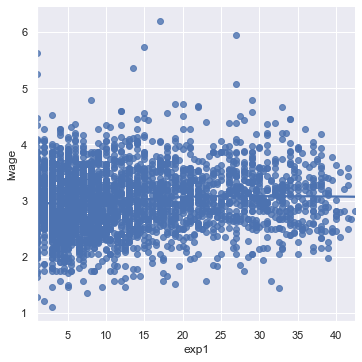

In [100]:
sns.lmplot(x="exp1", y="lwage", data=Z_data,
           lowess=True);